# Classification of stable vs. progressive mild cognitive impairment (MCI).

Compare a conventional, domain adversarial, and mixed effects multi-level perceptron/dense neural network (MLP) for the classification of stable vs. progressive MCI from multi-site data. 

Target: progressive MCI is defined as conversion to dementia within 24 months of sample acquisition.

Data: from the ADNIMERGE preprocessed dataset of the ADNI study. This includes demographic, cognitive, genetic, CSF, PET, and structural MRI measurements. The 20 largest sites have been selected and divided into 10x10 nested k-folds (see `create_kfolds.py`). The remaining data has been reserved for evaluation. 

Run to select GPU and restrict memory usage to 20%.

In [ ]:
# from armed.tfutils import set_gpu
# set_gpu(1, 0.2)

In [ ]:
import os
# Suppress unneeded tensorflow log info
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from armed.tfutils import set_gpu
from armed.models.mlp_classifiers import BaseMLP, ClusterCovariateMLP, DomainAdversarialMLP, MixedEffectsMLP

from armed.metrics import classification_metrics
from armed.settings import RESULTSDIR

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import stats

tf.get_logger().setLevel('ERROR')

In [19]:
strOutputDir = os.path.join(RESULTSDIR, 'mci_conversion_20211101/4model_comparison_probe_features_5_updatedlinearslope')
os.makedirs(strOutputDir, exist_ok=True)

Load pickled k-folds.

In [20]:
with open('./10x10_kfolds_top20sites.pkl', 'rb') as f:
    kfolds = pickle.load(f)
    
with open('./10x10_kfolds_top20sites_heldout_sites.pkl', 'rb') as f:
    dfXHeldout, dfZHeldout, arrYHeldout = pickle.load(f)
    
dfSiteLabel = kfolds.z.idxmax(axis=1).to_frame('Site')
dfSiteLabel['Label'] = kfolds.y
dfSiteConversionRate = dfSiteLabel.groupby('Site').mean()

Dataset characteristics.

In [21]:
print(kfolds.x.shape[0], 'subjects')
print(kfolds.x.shape[1], 'features')
print('{:.03f}% converters'.format(kfolds.y.mean() * 100))

392 subjects
37 features
27.041% converters


In [22]:
def add_probes(x, z):
    dfSite = z.idxmax(axis=1)

    xnew = x.copy()    
    xnew['Probe 1'] = dfSite.apply(lambda s: dfSiteConversionRate['Label'].loc[s]) + \
        np.random.normal(loc=0, scale=0.05, size=(xnew.shape[0]))
    xnew['Probe 2'] = dfSite.apply(lambda s: dfSiteConversionRate['Label'].loc[s]**2) + \
        np.random.normal(loc=0, scale=0.05, size=(xnew.shape[0]))
    xnew['Probe 3'] = dfSite.apply(lambda s: 1 / dfSiteConversionRate['Label'].loc[s]) + \
        np.random.normal(loc=0, scale=0.05, size=(xnew.shape[0]))
    xnew['Probe 4'] = dfSite.apply(lambda s: np.cos(dfSiteConversionRate['Label'].loc[s])) + \
        np.random.normal(loc=0, scale=0.05, size=(xnew.shape[0]))
    xnew['Probe 5'] = dfSite.apply(lambda s: np.sin(dfSiteConversionRate['Label'].loc[s])) + \
        np.random.normal(loc=0, scale=0.05, size=(xnew.shape[0]))
    
    return xnew

In [23]:
kfolds.x = add_probes(kfolds.x, kfolds.z)
dfXHeldout[['Probe 1', 'Probe 2', 'Probe 3', 'Probe 4', 'Probe 5']] = 0

Define some functions for performing cross-validation and computing feature importance via partial derivatives. 

In [24]:
def get_fold_data(outer_fold, inner_fold=None):
    """Return training and validation data, cluster membership design matrix, and labels 
    for a specified fold. Also return the data for the held-out sites, with the cluster 
    membership design matrix inferred using a random forest trained on the data from 
    seen sites. 

    Args:
        outer_fold (int): Outer fold index.
        inner_fold (int, optional): Inner fold index. Defaults to None.

    Returns:
        (train data, train clusters), train labels, (val data, val clusters), val labels,
            (heldout data, heldout clusters), heldout labels
    """    
    
    dfXTrain, dfZTrain, arrYTrain, dfXVal, dfZVal, arrYVal = kfolds.get_fold(outer_fold, idx_inner=inner_fold)

    dfXTrain = add_probes(dfXTrain, dfZTrain)
    dfXVal = add_probes(dfXVal, dfZVal)

    scaler = StandardScaler()
    imputer = SimpleImputer()

    arrXTrain = scaler.fit_transform(dfXTrain)
    arrXTrain = imputer.fit_transform(arrXTrain).astype(np.float32)
    arrXVal = scaler.transform(dfXVal)
    arrXVal = imputer.transform(arrXVal).astype(np.float32)
    arrXHeldout = scaler.transform(dfXHeldout)
    arrXHeldout = imputer.transform(arrXHeldout).astype(np.float32)
    
    # Try to infer the design matrix for the heldout sites
    clf = RandomForestClassifier()
    clf.fit(arrXTrain, dfZTrain.idxmax(axis=1))
    arrPredZ = clf.predict(arrXHeldout)
    dfZHeldoutPred = dfZHeldout.copy()
    for i, site in enumerate(arrPredZ):
        dfZHeldoutPred.loc[dfZHeldoutPred.index[i], site] = 1

    return (arrXTrain, dfZTrain.astype(np.float32)), arrYTrain, (arrXVal, dfZVal.astype(np.float32)), arrYVal, \
        (arrXHeldout, dfZHeldoutPred.astype(np.float32)), arrYHeldout
    
def compute_grads(model, inputs):
    """Compute feature gradients/partial derivatives.

    Args:
        model: trained model
        inputs (array or tuple): model inputs

    Returns:
        pd.DataFrame: feature gradients
    """    

    if isinstance(inputs, tuple):
        x, z = inputs
        x = x.mean(axis=0).reshape((1, -1))
        # Use all zero design matrix, since for the ME-MLP we 
        # only want to measure the feature sensitivity of the 
        # fixed effects submodel.
        z = np.zeros((1, z.shape[1]), dtype=np.float32)
        
        with tf.GradientTape() as gt:
            tx = tf.constant(x)
            tz = tf.zeros_like(z)
            gt.watch(tx)
            gt.watch(tz)
            ty = model((tx, tz))
            
        dydx = gt.gradient(ty, tx)

    else:
        x = inputs
        x = x.mean(axis=0).reshape((1, -1))
        with tf.GradientTape() as gt:
            tx = tf.constant(x)
            gt.watch(tx)
            ty = model(tx)
            
        dydx = gt.gradient(ty, tx)

    dfGrads = pd.DataFrame(np.abs(dydx.numpy()), columns=kfolds.x.columns)
    return pd.melt(dfGrads, var_name='Feature', value_name='Gradient')
    
def compute_random_slope_sd(model):
    """Compute the inter-cluster variances of the ME-MLP's learned random slopes.

    Args:
        model: trained model

    Returns:
        pd.DataFrame: s.d. for each feature
    """    
    arrRandomSlopePosterior = model.randomeffects.re_slope.weights[0].numpy()
    nClusters = kfolds.z.shape[1]
    nFeatures = kfolds.x.shape[1]
    nWeights = nClusters * nFeatures
    arrRandomSlope = arrRandomSlopePosterior[:nWeights]
    arrRandomSlope = arrRandomSlope.reshape((nClusters, nFeatures))

    return pd.DataFrame({'Feature': kfolds.x.columns, 'S.D.': arrRandomSlope.std(axis=0)})
    
def get_random_intercepts(model):
    """Get the learned random intercepts from the trained ME-MLP.

    Args:
        model: trained model

    Returns:
        pd.DataFrame: Site-specific random intercepts
    """    
    arrRandomIntPosterior = model.randomeffects.re_int.weights[0].numpy()
    nClusters = kfolds.z.shape[1]
    arrRandomInt = arrRandomIntPosterior[:nClusters]
    
    return pd.DataFrame({'Site': kfolds.z.columns, 'Random intercept': arrRandomInt})
    
def cross_validate(model_class, outer_fold=None, use_z=False, evaluate_heldout_sites=False, 
                   build_args={}, compile_args={}):
    """Perform cross-validation and compute feature gradients. Specify outer_fold to perform
    cross-validation on one of the inner k-folds (e.g. to tune hyperparameters), otherwise 
    use the outer k-folds for final evaluation. 

    Args:
        model_class: Model class.
        outer_fold (int, optional): Outer fold index. Defaults to None.
        use_z (bool, optional): Model takes design matrix as second input. Defaults to False.
        evaluate_heldout_sites (bool, optional): Evaluate model on held-out sites. Defaults to False.
        build_args (dict, optional): Model constructor arguments. Defaults to {}.
        compile_args (dict, optional): Compilation arguments. Defaults to {}.

    Returns:
        for ME-MLP:
            cross-validated metrics, feature gradients, random slope variances, random intercepts
        for other models:
            cross-validated metrics, feature gradients
    """    
    
    lsResults = []
    lsGrads = []
    if model_class == MixedEffectsMLP:
        lsRandomSlopeSD = [] 
        lsRandomInt = []  
    
    if outer_fold:
        nFolds = kfolds.n_folds
    else:
        nFolds = kfolds.n_folds_inner
    
    for iFold in range(nFolds):
        if outer_fold:
            (xTrain, zTrain), labelTrain, (xVal, zVal), labelVal, \
                (xHeldout, zHeldout), labelHeldout = get_fold_data(outer_fold, iFold)
        else:
            (xTrain, zTrain), labelTrain, (xVal, zVal), labelVal, \
                (xHeldout, zHeldout), labelHeldout = get_fold_data(iFold)
                
        tf.random.set_seed(283)
        model = model_class(**build_args)
        if use_z:
            dataTrain = (xTrain, zTrain)
            dataVal = (xVal, zVal)
            dataHeldout = (xHeldout, zHeldout)
        else:
            dataTrain = xTrain
            dataVal = xVal            
            dataHeldout = xHeldout
            
        model.compile(**compile_args)
        
        dictClassWeights = {0: labelTrain.mean(), 1: (1 - labelTrain.mean())}
        lsCallbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_auprc', 
                                                        mode='max',
                                                        patience=5, 
                                                        restore_best_weights=True)]

        log = model.fit(dataTrain, labelTrain,
                        validation_data=(dataVal, labelVal),
                        callbacks=lsCallbacks,
                        epochs=50,
                        verbose=0,
                        class_weight=dictClassWeights)
        
        arrPredTrain = model.predict(dataTrain)
        if isinstance(arrPredTrain, tuple):
            arrPredTrain = arrPredTrain[0]
        dictMetrics, youden = classification_metrics(labelTrain, arrPredTrain)
                
        arrPredVal = model.predict(dataVal)
        if isinstance(arrPredVal, tuple):
            arrPredVal = arrPredVal[0]
        dictMetricsVal, _ = classification_metrics(labelVal, arrPredVal, youden)
        for k, v in dictMetricsVal.items():
            dictMetrics['Val_' + k] = v
            
        if evaluate_heldout_sites:
            arrPredHeldout = model.predict(dataHeldout)
            if isinstance(arrPredHeldout, tuple):
                arrPredHeldout = arrPredHeldout[0]
            try:
                dictMetricsHeldout, _ = classification_metrics(labelHeldout, arrPredHeldout, youden)
            except:
                print(arrPredHeldout)
            for k, v in dictMetricsHeldout.items():
                dictMetrics['Heldout_' + k] = v
        
        lsResults += [dictMetrics]
        lsGrads += [compute_grads(model, dataTrain)]
        
        if model_class == MixedEffectsMLP:
            lsRandomSlopeSD += [compute_random_slope_sd(model)]
            lsRandomInt += [get_random_intercepts(model)]
        
    dfResults = pd.DataFrame(lsResults)
    dfGrads = pd.concat(lsGrads, axis=0)
    if model_class == MixedEffectsMLP:
        dfRandomSlopeSD = pd.concat(lsRandomSlopeSD, axis=0)
        dfRandomIntercept = pd.concat(lsRandomInt, axis=0)
        return dfResults, dfGrads, dfRandomSlopeSD, dfRandomIntercept
    else:
        return dfResults, dfGrads
        

## Conventional model

AUROC                     0.889989
Accuracy                  0.849156
Youden's index            0.698311
F1                        0.740501
PPV                       0.649627
NPV                       0.957899
Sensitivity               0.905757
Specificity               0.821359
Val_AUROC                 0.880172
Val_Accuracy              0.785630
Val_Youden's index        0.571261
Val_F1                    0.666667
Val_PPV                   0.558442
Val_NPV                   0.935223
Val_Sensitivity           0.859091
Val_Specificity           0.807266
Heldout_AUROC             0.814024
Heldout_Accuracy          0.730601
Heldout_Youden's index    0.461203
Heldout_F1                0.652778
Heldout_PPV               0.752378
Heldout_NPV               0.777159
Heldout_Sensitivity       0.581301
Heldout_Specificity       0.879902
dtype: float64


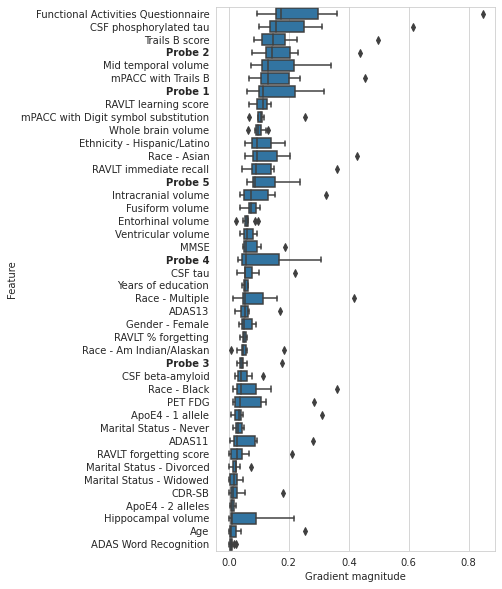

In [25]:
dictCompile = {'loss':tf.keras.losses.BinaryCrossentropy(),
                'metrics': tf.keras.metrics.AUC(curve='PR', name='auprc'),
                'optimizer': tf.keras.optimizers.Adam(lr=0.001)}
dfResultsBase, dfGradsBase = cross_validate(BaseMLP, evaluate_heldout_sites=True, compile_args=dictCompile)

lsSortOrder = dfGradsBase.groupby('Feature').median().sort_values('Gradient', ascending=False).index
fig, ax = plt.subplots(figsize=(5, 10))
sns.boxplot(data=dfGradsBase, x='Gradient', y='Feature', orient='h', order=lsSortOrder, ax=ax,
            color='C0')
ax.set_xlabel('Gradient magnitude')
for t in ax.get_yticklabels():
    if 'Probe' in t.get_text():
        t.set_fontweight('bold')

fig.savefig(os.path.join(strOutputDir, 'conventional.svg'), bbox_inches='tight')
fig.savefig(os.path.join(strOutputDir, 'conventional.png'), bbox_inches='tight')

print(dfResultsBase.median())

## Using cluster as another input

AUROC                     0.895767
Accuracy                  0.865146
Youden's index            0.730293
F1                        0.760386
PPV                       0.655281
NPV                       0.959611
Sensitivity               0.905702
Specificity               0.823304
Val_AUROC                 0.901959
Val_Accuracy              0.839526
Val_Youden's index        0.679053
Val_F1                    0.732441
Val_PPV                   0.636029
Val_NPV                   0.940705
Val_Sensitivity           0.854545
Val_Specificity           0.824507
Heldout_AUROC             0.821477
Heldout_Accuracy          0.762912
Heldout_Youden's index    0.525825
Heldout_F1                0.705795
Heldout_PPV               0.691513
Heldout_NPV               0.819274
Heldout_Sensitivity       0.691057
Heldout_Specificity       0.813725
dtype: float64


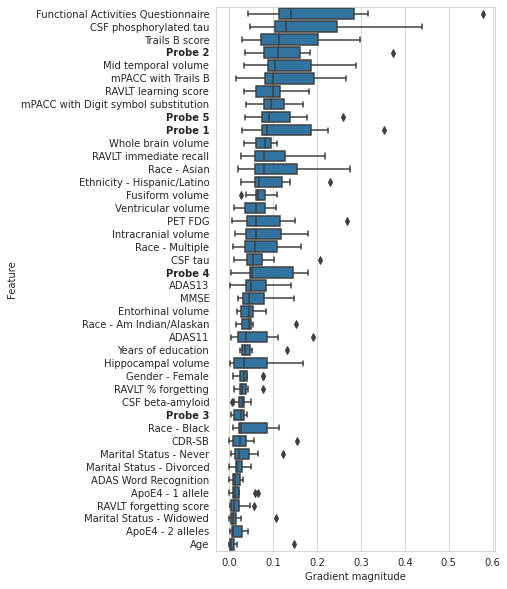

In [26]:
dictCompile = {'loss':tf.keras.losses.BinaryCrossentropy(),
                'metrics': tf.keras.metrics.AUC(curve='PR', name='auprc'),
                'optimizer': tf.keras.optimizers.Adam(lr=0.001)}
dfResultsConcat, dfGradsConcat = cross_validate(ClusterCovariateMLP, use_z=True, 
                                                evaluate_heldout_sites=True, compile_args=dictCompile)

lsSortOrder = dfGradsConcat.groupby('Feature').median().sort_values('Gradient', ascending=False).index
fig, ax = plt.subplots(figsize=(5, 10))
sns.boxplot(data=dfGradsConcat, x='Gradient', y='Feature', orient='h', order=lsSortOrder, ax=ax,
            color='C0')
ax.set_xlabel('Gradient magnitude')
for t in ax.get_yticklabels():
    if 'Probe' in t.get_text():
        t.set_fontweight('bold')

fig.savefig(os.path.join(strOutputDir, 'clusterinput.svg'), bbox_inches='tight')
fig.savefig(os.path.join(strOutputDir, 'clusterinput.png'), bbox_inches='tight')

print(dfResultsConcat.median())

## Domain adversarial model

AUROC                     0.807209
Accuracy                  0.767139
Youden's index            0.534279
F1                        0.637943
PPV                       0.543377
NPV                       0.897743
Sensitivity               0.753838
Specificity               0.772374
Val_AUROC                 0.814465
Val_Accuracy              0.740209
Val_Youden's index        0.480419
Val_F1                    0.607642
Val_PPV                   0.500000
Val_NPV                   0.896825
Val_Sensitivity           0.763636
Val_Specificity           0.789409
Heldout_AUROC             0.685328
Heldout_Accuracy          0.550395
Heldout_Youden's index    0.100789
Heldout_F1                0.189232
Heldout_PPV               0.872211
Heldout_NPV               0.648591
Heldout_Sensitivity       0.105691
Heldout_Specificity       0.990196
dtype: float64


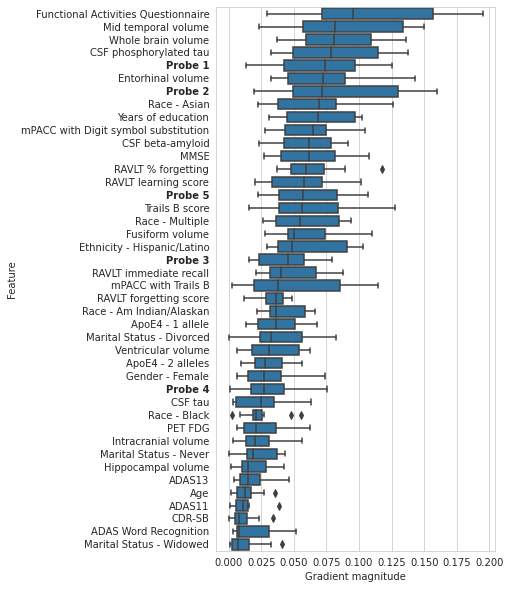

In [27]:
dictBuild = {'n_clusters': kfolds.z.shape[1], 'adversary_layer_units': [8, 8, 4]}
dictCompile = {'loss_gen_weight': 10.0}
dfResultsDA, dfGradsDA = cross_validate(DomainAdversarialMLP, use_z=True, evaluate_heldout_sites=True,
                                        build_args=dictBuild, compile_args=dictCompile)

lsSortOrder = dfGradsDA.groupby('Feature').median().sort_values('Gradient', ascending=False).index
fig, ax = plt.subplots(figsize=(5, 10))
sns.boxplot(data=dfGradsDA, x='Gradient', y='Feature', orient='h', order=lsSortOrder, ax=ax, 
            color='C0')
ax.set_xlabel('Gradient magnitude')
for t in ax.get_yticklabels():
    if 'Probe' in t.get_text():
        t.set_fontweight('bold')
        
fig.savefig(os.path.join(strOutputDir, 'domainadversarial.svg'), bbox_inches='tight')
fig.savefig(os.path.join(strOutputDir, 'domainadversarial.png'), bbox_inches='tight')
        
print(dfResultsDA.median())

## Mixed effects model, no domain adversarial subnetwork

AUROC                     0.973837
Accuracy                  0.936335
Youden's index            0.872669
F1                        0.890586
PPV                       0.855069
NPV                       0.975990
Sensitivity               0.936842
Specificity               0.941747
Val_AUROC                 0.920690
Val_Accuracy              0.759639
Val_Youden's index        0.519279
Val_F1                    0.651515
Val_PPV                   0.700893
Val_NPV                   0.879928
Val_Sensitivity           0.668182
Val_Specificity           0.876847
Heldout_AUROC             0.844831
Heldout_Accuracy          0.744201
Heldout_Youden's index    0.488403
Heldout_F1                0.681519
Heldout_PPV               0.762640
Heldout_NPV               0.798291
Heldout_Sensitivity       0.630081
Heldout_Specificity       0.882353
dtype: float64


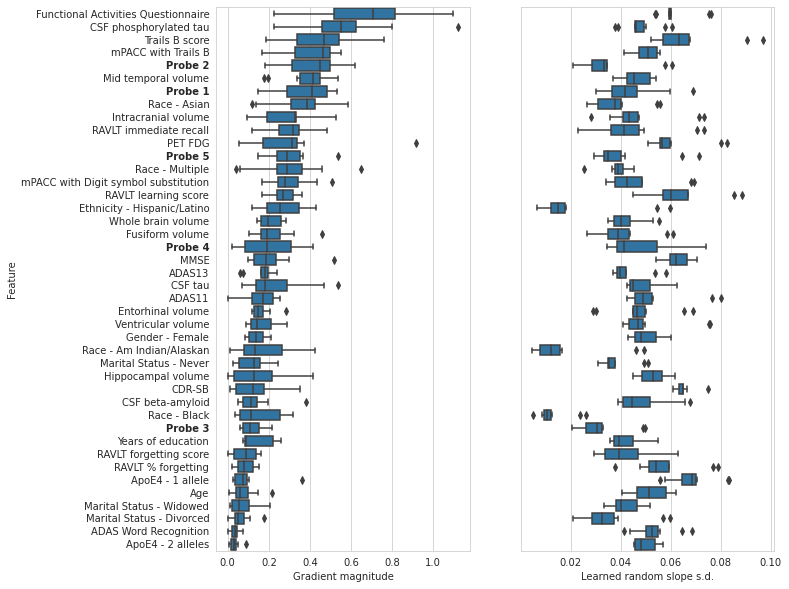

In [28]:
dictBuild = {'n_features': kfolds.x.shape[1],
             'n_clusters': kfolds.z.shape[1],
             'adversary_layer_units': [8, 8, 4],
             'slope_posterior_init_scale': 0.1, 
             'intercept_posterior_init_scale': 0.1, 
             'slope_prior_scale': 0.15, 
             'intercept_prior_scale': 0.1,
             'kl_weight': 0.001}
dictCompile = {'loss_class_fe_weight': 1.0, 'loss_gen_weight': 0., 'loss_class_me_weight': 1.0}
dfResultsME, dfGradsME, dfRandomSlopeSD, dfRandomIntercept = cross_validate(MixedEffectsMLP,  
                                                                            use_z=True, 
                                                                            evaluate_heldout_sites=True,
                                                                            build_args=dictBuild, 
                                                                            compile_args=dictCompile)

fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
lsSortOrder = dfGradsME.groupby('Feature').median().sort_values('Gradient', ascending=False).index
sns.boxplot(data=dfGradsME, x='Gradient', y='Feature', orient='h', order=lsSortOrder, ax=ax[0], color='C0')
sns.boxplot(data=dfRandomSlopeSD, x='S.D.', y='Feature', orient='h', order=lsSortOrder, ax=ax[1], color='C0')
ax[0].set_xlabel('Gradient magnitude')
for t in ax[0].get_yticklabels():
    if 'Probe' in t.get_text():
        t.set_fontweight('bold')

ax[1].set_ylabel(None)
ax[1].set_xlabel('Learned random slope s.d.')

fig.savefig(os.path.join(strOutputDir, 'mixedeffects_no_da.svg'), bbox_inches='tight')
fig.savefig(os.path.join(strOutputDir, 'mixedeffects_no_da.png'), bbox_inches='tight')

print(dfResultsME.median())

## Mixed effects model, no domain adversarial subnetwork

AUROC                     0.977074
Accuracy                  0.942056
Youden's index            0.884112
F1                        0.899053
PPV                       0.851203
NPV                       0.977844
Sensitivity               0.942379
Specificity               0.937856
Val_AUROC                 0.916111
Val_Accuracy              0.794934
Val_Youden's index        0.589868
Val_F1                    0.693333
Val_PPV                   0.665179
Val_NPV                   0.894444
Val_Sensitivity           0.713636
Val_Specificity           0.860222
Heldout_AUROC             0.849334
Heldout_Accuracy          0.751046
Heldout_Youden's index    0.502092
Heldout_F1                0.693318
Heldout_PPV               0.677083
Heldout_NPV               0.823977
Heldout_Sensitivity       0.719512
Heldout_Specificity       0.791667
dtype: float64


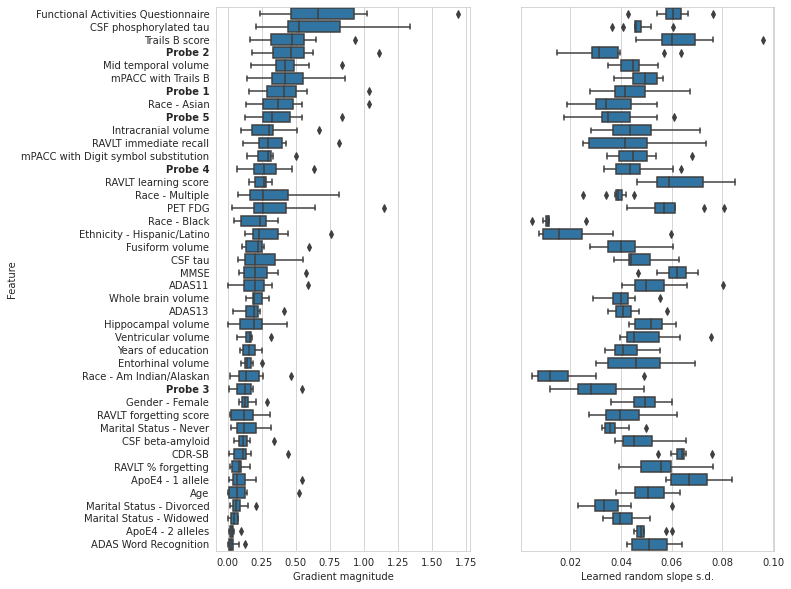

In [29]:
dictBuild = {'n_features': kfolds.x.shape[1],
             'n_clusters': kfolds.z.shape[1],
             'adversary_layer_units': [8, 8, 4],
             'slope_posterior_init_scale': 0.1, 
             'intercept_posterior_init_scale': 0.1, 
             'slope_prior_scale': 0.15, 
             'intercept_prior_scale': 0.1,
             'kl_weight': 0.001}
dictCompile = {'loss_class_fe_weight': 0.5, 'loss_gen_weight': 0., 'loss_class_me_weight': 1.0}
dfResultsME, dfGradsME, dfRandomSlopeSD, dfRandomIntercept = cross_validate(MixedEffectsMLP,  
                                                                            use_z=True, 
                                                                            evaluate_heldout_sites=True,
                                                                            build_args=dictBuild, 
                                                                            compile_args=dictCompile)

fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
lsSortOrder = dfGradsME.groupby('Feature').median().sort_values('Gradient', ascending=False).index
sns.boxplot(data=dfGradsME, x='Gradient', y='Feature', orient='h', order=lsSortOrder, ax=ax[0], color='C0')
sns.boxplot(data=dfRandomSlopeSD, x='S.D.', y='Feature', orient='h', order=lsSortOrder, ax=ax[1], color='C0')
ax[0].set_xlabel('Gradient magnitude')
for t in ax[0].get_yticklabels():
    if 'Probe' in t.get_text():
        t.set_fontweight('bold')

ax[1].set_ylabel(None)
ax[1].set_xlabel('Learned random slope s.d.')

fig.savefig(os.path.join(strOutputDir, 'mixedeffects_noda.svg'), bbox_inches='tight')
fig.savefig(os.path.join(strOutputDir, 'mixedeffects_noda.png'), bbox_inches='tight')

print(dfResultsME.median())

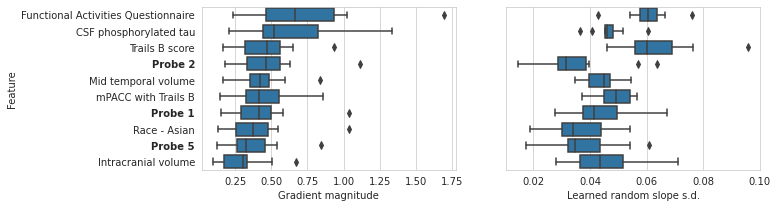

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
lsSortOrder = dfGradsME.groupby('Feature').median().sort_values('Gradient', ascending=False).index[:10]
sns.boxplot(data=dfGradsME, x='Gradient', y='Feature', orient='h', order=lsSortOrder, ax=ax[0], color='C0')
sns.boxplot(data=dfRandomSlopeSD, x='S.D.', y='Feature', orient='h', order=lsSortOrder, ax=ax[1], color='C0')
ax[0].set_xlabel('Gradient magnitude')
for t in ax[0].get_yticklabels():
    if 'Probe' in t.get_text():
        t.set_fontweight('bold')

ax[1].set_ylabel(None)
ax[1].set_xlabel('Learned random slope s.d.')

fig.savefig(os.path.join(strOutputDir, 'mixedeffects_noda_top10.svg'), bbox_inches='tight')
fig.savefig(os.path.join(strOutputDir, 'mixedeffects_noda_top10.png'), bbox_inches='tight')

## Mixed effects model, including domain adversarial subnetwork

AUROC                     0.978117
Accuracy                  0.939498
Youden's index            0.878996
F1                        0.882029
PPV                       0.814815
NPV                       0.979592
Sensitivity               0.947643
Specificity               0.922481
Val_AUROC                 0.893182
Val_Accuracy              0.788261
Val_Youden's index        0.576523
Val_F1                    0.681159
Val_PPV                   0.601810
Val_NPV                   0.886429
Val_Sensitivity           0.727273
Val_Specificity           0.824507
Heldout_AUROC             0.812470
Heldout_Accuracy          0.702774
Heldout_Youden's index    0.405548
Heldout_F1                0.643944
Heldout_PPV               0.631900
Heldout_NPV               0.788867
Heldout_Sensitivity       0.654472
Heldout_Specificity       0.776961
dtype: float64


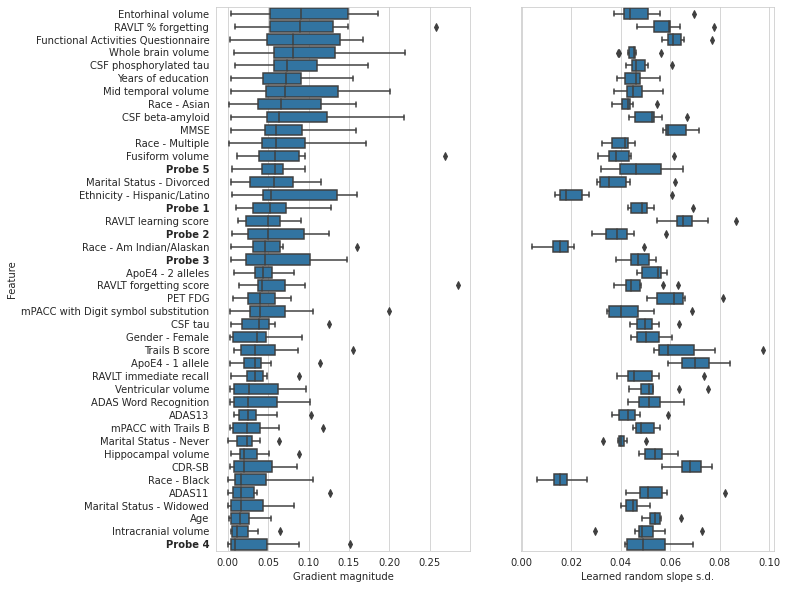

In [31]:
dictBuild = {'n_features': kfolds.x.shape[1],
             'n_clusters': kfolds.z.shape[1],
             'adversary_layer_units': [8, 8, 4],
             'slope_posterior_init_scale': 0.1, 
             'intercept_posterior_init_scale': 0.1, 
             'slope_prior_scale': 0.15, 
             'intercept_prior_scale': 0.1,
             'kl_weight': 0.001}
dictCompile = {'loss_class_fe_weight': 0.5, 'loss_gen_weight': 40., 'loss_class_me_weight': 1.0}
dfResultsME, dfGradsME, dfRandomSlopeSD, dfRandomIntercept = cross_validate(MixedEffectsMLP,  
                                                                            use_z=True, 
                                                                            evaluate_heldout_sites=True,
                                                                            build_args=dictBuild, 
                                                                            compile_args=dictCompile)

fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
lsSortOrder = dfGradsME.groupby('Feature').median().sort_values('Gradient', ascending=False).index
sns.boxplot(data=dfGradsME, x='Gradient', y='Feature', orient='h', order=lsSortOrder, ax=ax[0], color='C0')
sns.boxplot(data=dfRandomSlopeSD, x='S.D.', y='Feature', orient='h', order=lsSortOrder, ax=ax[1], color='C0')
ax[0].set_xlabel('Gradient magnitude')
for t in ax[0].get_yticklabels():
    if 'Probe' in t.get_text():
        t.set_fontweight('bold')

ax[1].set_ylabel(None)
ax[1].set_xlabel('Learned random slope s.d.')

# fig.savefig(os.path.join(strOutputDir, 'mixedeffects.svg'), bbox_inches='tight')
# fig.savefig(os.path.join(strOutputDir, 'mixedeffects.png'), bbox_inches='tight')

print(dfResultsME.median())

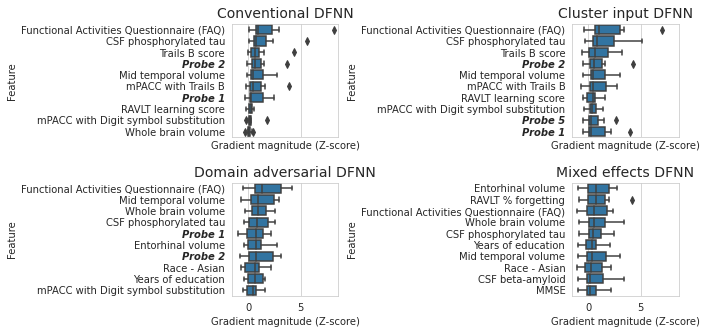

In [63]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5), gridspec_kw={'wspace': 2.2, 'hspace': 0.4}, sharex=True)

for i, (name, df) in enumerate({'Conventional DFNN': dfGradsBase,
                                'Cluster input DFNN': dfGradsConcat,
                                'Domain adversarial DFNN': dfGradsDA,
                                'Mixed effects DFNN': dfGradsME}.items()):
    df2 = df.copy()
    df2['Feature'].replace({'Functional Activities Questionnaire': 'Functional Activities Questionnaire (FAQ)'}, inplace=True)
    df2['Gradient'] -= df2['Gradient'].mean()
    df2['Gradient'] /= df2['Gradient'].std()
    
    axis = ax.flatten()[i]
    lsSortOrder = df2.groupby('Feature').median().sort_values('Gradient', ascending=False).index
    sns.boxplot(data=df2, x='Gradient', y='Feature', orient='h', order=lsSortOrder[:10], ax=axis, color='C0')
    axis.set_title(name, size=14)
    axis.set_xlabel('Gradient magnitude (Z-score)')
    for t in axis.get_yticklabels():    
        if 'Probe' in t.get_text():
            t.set_fontweight('extra bold')
            t.set_fontstyle('italic')
            
fig.savefig('top10_features_compared.png', bbox_inches='tight')
fig.savefig('top10_features_compared.svg', bbox_inches='tight')